<a href="https://colab.research.google.com/github/marcosmrego/Python/blob/master/Tesouro_Direto_em_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Estudo em Python para Investimentos - Tesouro Direto

### Importações e configurações iniciais

In [3]:
import pandas as pd
pd.set_option("display.max_colwidth", 150)
pd.set_option("display.min_rows", 20)

import matplotlib
matplotlib.style.use('seaborn-darkgrid')
matplotlib.rcParams['figure.figsize'] = (18,8)

import plotly.graph_objects as go
import plotly.express as px

In [4]:
!pip install yfinance
import yfinance as yf

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=9a65304940e0df91c0e8bf516443091954363ee02e9249380a458a27ce4b2fc7
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [5]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### 1. Funções para Busca e Tratamento de Dados do Tesouro Direto

In [6]:
def busca_titulos_tesouro_direto():
  url = 'https://www.tesourotransparente.gov.br/ckan/dataset/df56aa42-484a-4a59-8184-7676580c81e3/resource/796d2059-14e9-44e3-80c9-2d9e30b405c1/download/PrecoTaxaTesouroDireto.csv'
  df  = pd.read_csv(url, sep=';', decimal=',')
  df['Data Vencimento'] = pd.to_datetime(df['Data Vencimento'], dayfirst=True)
  df['Data Base']       = pd.to_datetime(df['Data Base'], dayfirst=True)
  multi_indice = pd.MultiIndex.from_frame(df.iloc[:, :3])
  df = df.set_index(multi_indice).iloc[: , 3:]  
  return df

In [7]:
def busca_vendas_tesouro():
  url = "https://www.tesourotransparente.gov.br/ckan/dataset/f0468ecc-ae97-4287-89c2-6d8139fb4343/resource/e5f90e3a-8f8d-4895-9c56-4bb2f7877920/download/VendasTesouroDireto.csv"
  df  = pd.read_csv(url, sep=';', decimal=',')
  df['Vencimento do Titulo'] = pd.to_datetime(df['Vencimento do Titulo'], dayfirst=True)
  df['Data Venda']       = pd.to_datetime(df['Data Venda'], dayfirst=True)
  multi_indice = pd.MultiIndex.from_frame(df.iloc[:, :3])
  df = df.set_index(multi_indice).iloc[: , 3:]  
  return df

In [8]:
def busca_recompras_tesouro():
  url = "https://www.tesourotransparente.gov.br/ckan/dataset/f30db6e4-6123-416c-b094-be8dfc823601/resource/30c2b3f5-6edd-499a-8514-062bfda0f61a/download/RecomprasTesouroDireto.csv"
  df  = pd.read_csv(url, sep=';', decimal=',')
  df['Vencimento do Titulo'] = pd.to_datetime(df['Vencimento do Titulo'], dayfirst=True)
  df['Data Resgate']       = pd.to_datetime(df['Data Resgate'], dayfirst=True)
  multi_indice = pd.MultiIndex.from_frame(df.iloc[:, :3])
  df = df.set_index(multi_indice).iloc[: , 3:]  
  return df

### 2.Preços e Taxas Históricas dos Títulos Negociados
Essa conjunto de dados contém as taxas e preços dos títulos ofertados pelo Tesouro Direto. Refletem o mercado secundário de títulos públicos federais.

### 2.1 Buscando dados

In [9]:
titulos = busca_titulos_tesouro_direto()

In [10]:
titulos.sort_index(inplace=True)
titulos

Taxa Compra Manha  ...  PU Base Manha
Tipo Titulo                        Data Vencimento Data Base                      ...               
Tesouro IGPM+ com Juros Semestrais 2005-07-01      2004-12-31               9.23  ...        1827.87
                                                   2005-01-03               9.23  ...        1776.51
                                                   2005-01-04               9.26  ...        1777.32
                                                   2005-01-05               9.28  ...        1778.20
                                                   2005-01-06               9.31  ...        1779.01
                                                   2005-01-07               9.87  ...        1775.73
                                                   2005-01-10              10.14  ...        1775.59
                                                   2005-01-11              10.26  ...        1775.79
                                                   2005-01-12              10.89  ...        1771.45
                                                   2005-01-13              10.89  ...        1772.52
...                                                                          ...  ...            ...
Tesouro Selic                      2025-03-01      2020-07-10               0.03  ...       10639.98
                                                   2020-07-13               0.03  ...       10640.90
                                                   2020-07-14               0.03  ...       10641.82
                                                   2020-07-15               0.03  ...       10642.73
                                                   2020-07-16               0.03  ...       10643.65
                                                   2020-07-17               0.03  ...       10644.57
                                                   2020-07-20               0.03  ...       10645.49
                                                   2020-07-21               0.03  ...       10646.40
                                                   2020-07-22               0.03  ...       10647.32
                                                   2020-07-23               0.03  ...       10648.19

[110035 rows x 5 columns]

In [11]:
tipos_titulos = titulos.index.droplevel(level=1).droplevel(level=1).drop_duplicates().to_list()
tipos_titulos

['Tesouro IGPM+ com Juros Semestrais',
 'Tesouro IPCA+',
 'Tesouro IPCA+ com Juros Semestrais',
 'Tesouro Prefixado',
 'Tesouro Prefixado com Juros Semestrais',
 'Tesouro Selic']

### 2.2 Tesouro Selic

In [12]:
selic2025 = titulos.loc[('Tesouro Selic', '2025-03-01')]
selic2025

,Taxa Compra Manha,Taxa Venda Manha,PU Compra Manha,PU Venda Manha,PU Base Manha
Data Base,,,,,
2019-02-01,0.02,0.06,9926.99,9902.94,9900.45
2019-02-04,0.02,0.06,9929.43,9905.40,9902.91
2019-02-05,0.02,0.06,9931.88,9907.87,9905.36
2019-02-06,0.02,0.06,9934.34,9910.33,9907.83
2019-02-07,0.02,0.06,9936.79,9912.80,9910.29
2019-02-08,0.02,0.06,9939.25,9915.26,9912.76
2019-02-11,0.02,0.06,9941.70,9917.72,9915.22
2019-02-12,0.02,0.06,9944.16,9920.19,9917.68
2019-02-13,0.02,0.06,9946.61,9922.65,9920.15


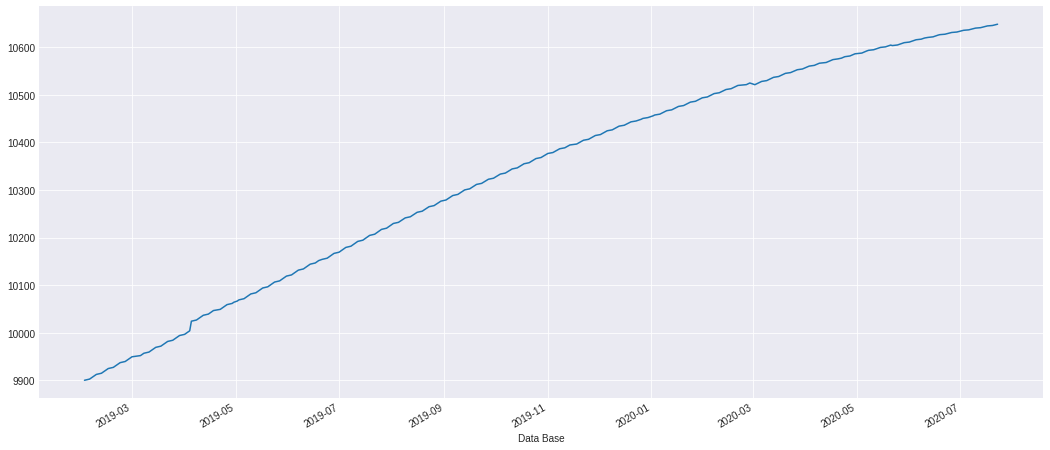

In [13]:
selic2025['PU Base Manha'].plot();

### 2.3 Pré-fixado 2023

In [14]:
pre2023 = titulos.loc[('Tesouro Prefixado', '2023-01-01')]
pre2023

,Taxa Compra Manha,Taxa Venda Manha,PU Compra Manha,PU Venda Manha,PU Base Manha
Data Base,,,,,
2016-01-26,16.59,16.65,346.72,345.49,345.28
2016-01-27,16.32,16.38,352.52,351.27,351.06
2016-01-28,16.42,16.48,350.65,349.41,349.20
2016-01-29,15.93,15.99,361.21,359.92,359.71
2016-02-01,15.89,15.95,362.28,360.99,360.78
2016-02-02,15.62,15.68,368.36,367.04,366.83
2016-02-03,15.90,15.96,362.49,361.20,360.99
2016-02-04,15.73,15.79,366.38,365.07,364.86
2016-02-05,15.99,16.05,360.98,359.70,359.49


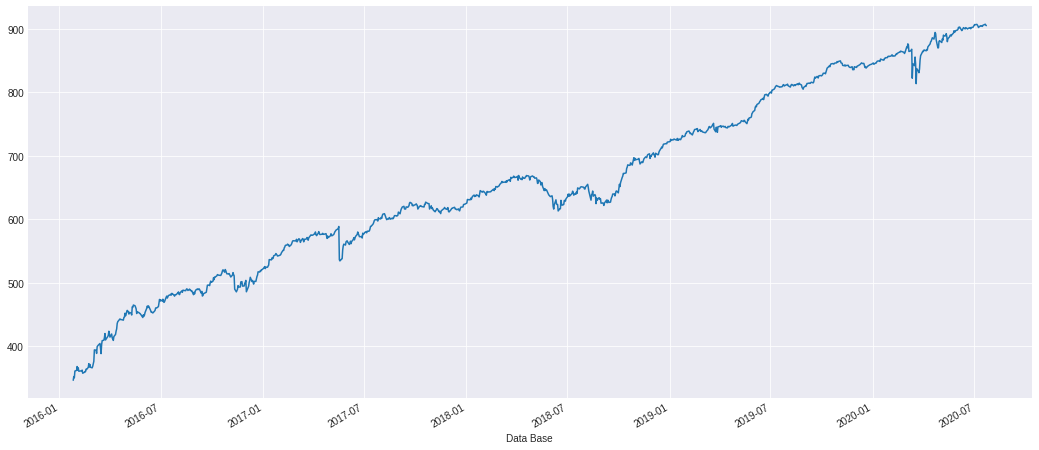

In [15]:
pre2023['PU Compra Manha'].plot();

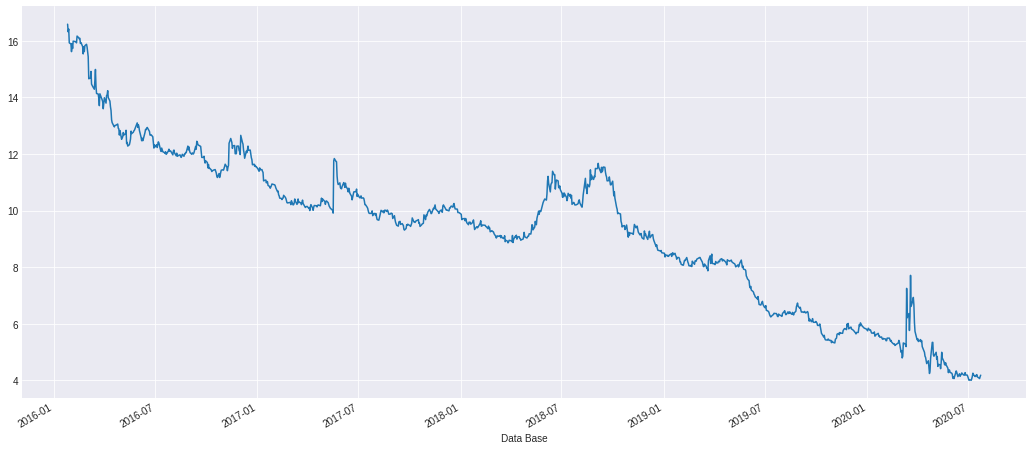

In [16]:
pre2023['Taxa Compra Manha'].plot();

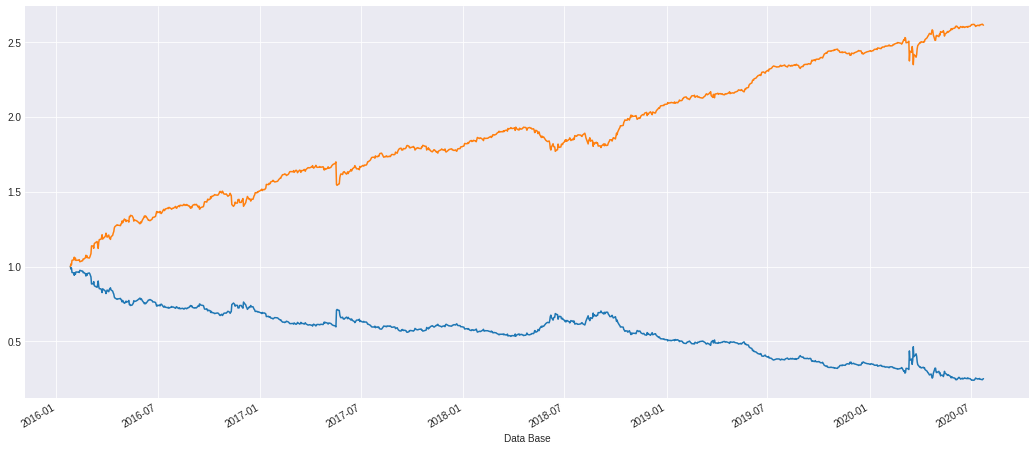

In [17]:
(pre2023['Taxa Compra Manha'] / pre2023['Taxa Compra Manha'].iloc[0]).plot();
(pre2023['PU Compra Manha'] / pre2023['PU Compra Manha'].iloc[0]).plot();

### 2.4 Pré-fixado 2026

In [18]:
pre2026 = titulos.loc[('Tesouro Prefixado', '2026-01-01')]
pre2026

,Taxa Compra Manha,Taxa Venda Manha,PU Compra Manha,PU Venda Manha,PU Base Manha
Data Base,,,,,
2020-02-10,6.36,6.48,696.02,691.42,691.25
2020-02-11,6.26,6.38,700.05,695.42,695.25
2020-02-12,6.22,6.34,701.76,697.13,696.96
2020-02-13,6.28,6.40,699.61,695.00,694.82
2020-02-14,6.23,6.35,701.71,697.08,696.91
2020-02-17,6.19,6.31,703.43,698.79,698.62
2020-02-18,6.21,6.33,702.82,698.19,698.02
2020-02-19,6.24,6.36,701.83,697.21,697.04
2020-02-20,6.21,6.33,703.16,698.53,698.36


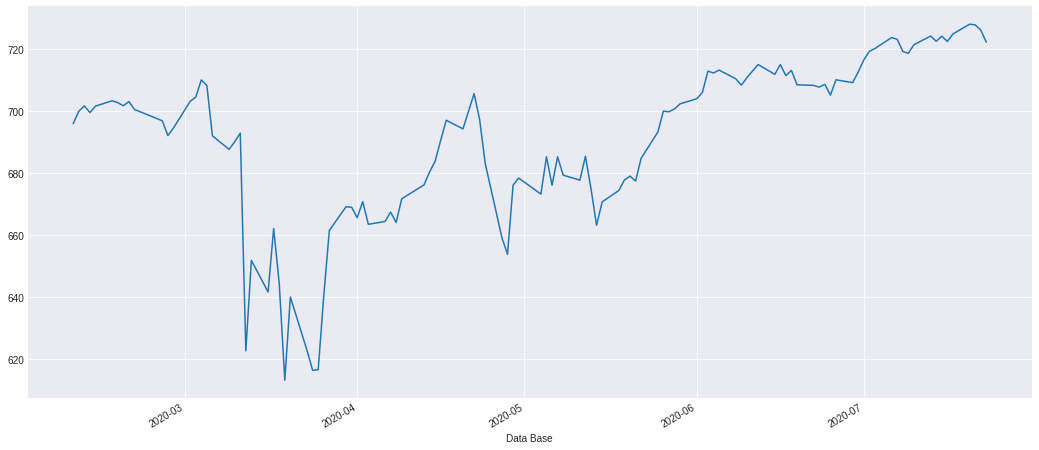

In [19]:
pre2026['PU Compra Manha'].plot();

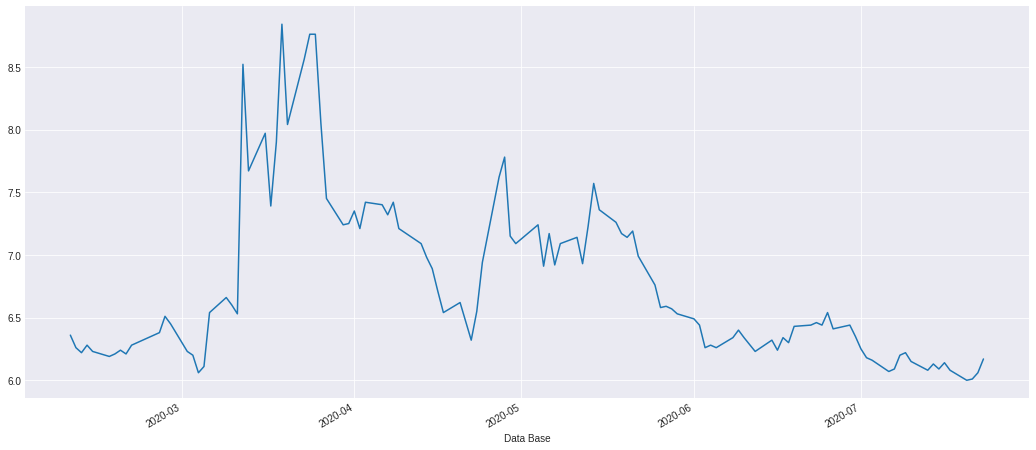

In [20]:
pre2026['Taxa Compra Manha'].plot();

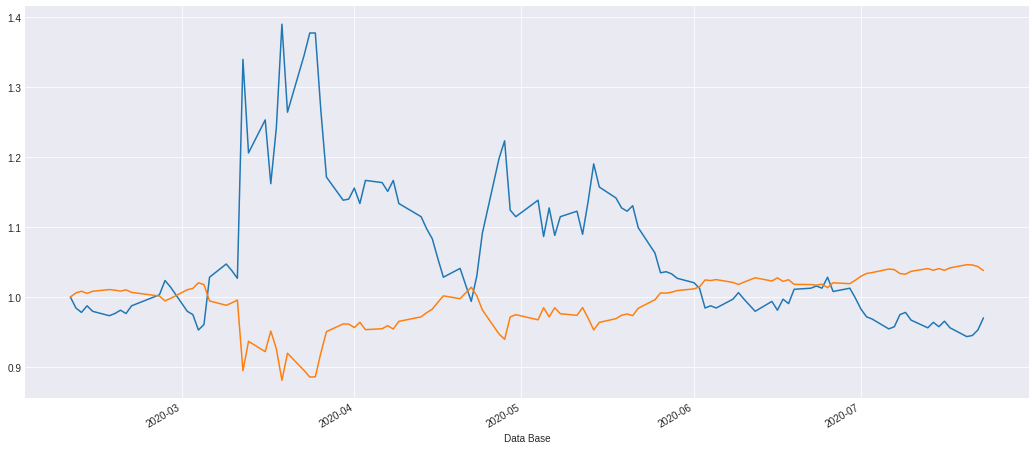

In [21]:
(pre2026['Taxa Compra Manha'] / pre2026['Taxa Compra Manha'].iloc[0]).plot();
(pre2026['PU Compra Manha'] / pre2026['PU Compra Manha'].iloc[0]).plot();

### 2.5 Pré-fixado 2031 com Juros Semestrais

In [22]:
pre2031 = titulos.loc[('Tesouro Prefixado com Juros Semestrais', '2031-01-01')]
pre2031

,Taxa Compra Manha,Taxa Venda Manha,PU Compra Manha,PU Venda Manha,PU Base Manha
Data Base,,,,,
2020-02-10,6.69,6.81,1257.57,1247.33,1247.00
2020-02-11,6.57,6.69,1268.26,1257.90,1257.57
2020-02-12,6.56,6.68,1269.45,1259.08,1258.76
2020-02-13,6.64,6.76,1262.85,1252.56,1252.23
2020-02-14,6.56,6.68,1270.09,1259.73,1259.40
2020-02-17,6.54,6.66,1272.15,1261.77,1261.45
2020-02-18,6.59,6.71,1268.13,1257.80,1257.48
2020-02-19,6.63,6.75,1265.00,1254.71,1254.39
2020-02-20,6.62,6.74,1266.18,1255.89,1255.56


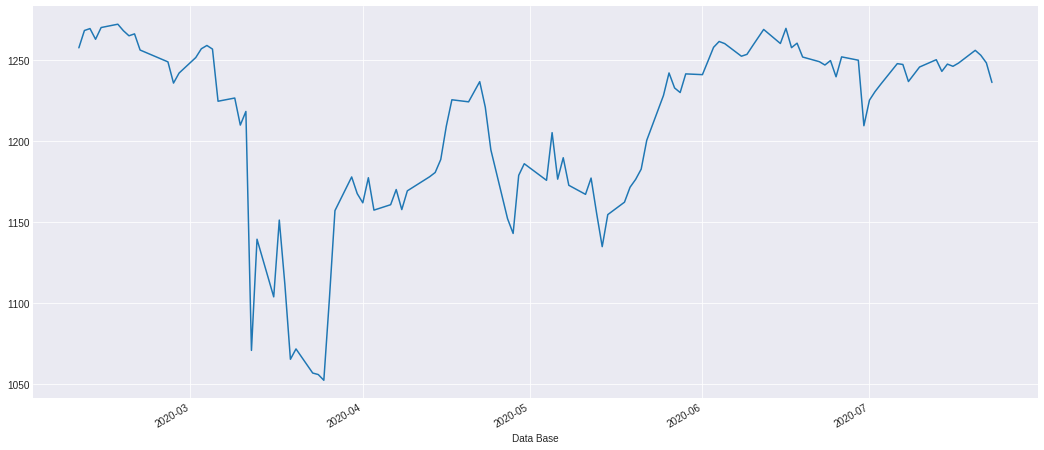

In [23]:
pre2031['PU Compra Manha'].plot();

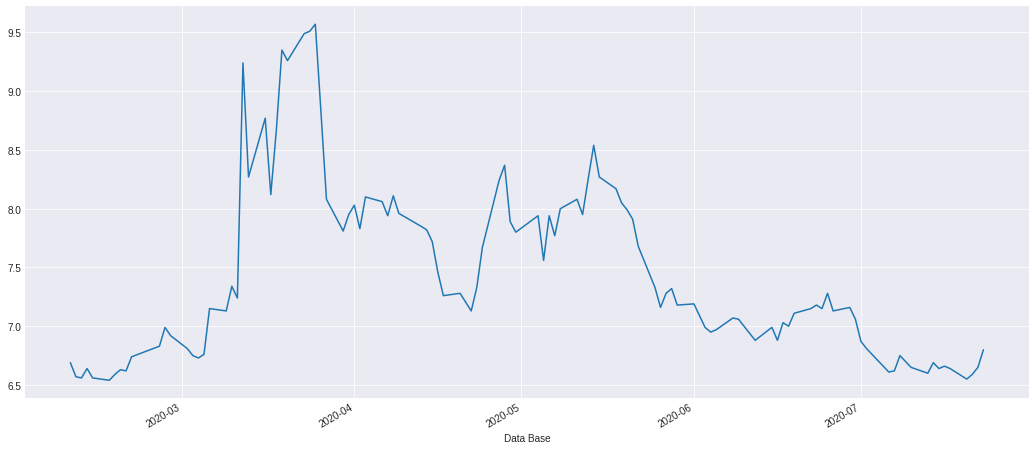

In [24]:
pre2031['Taxa Compra Manha'].plot();

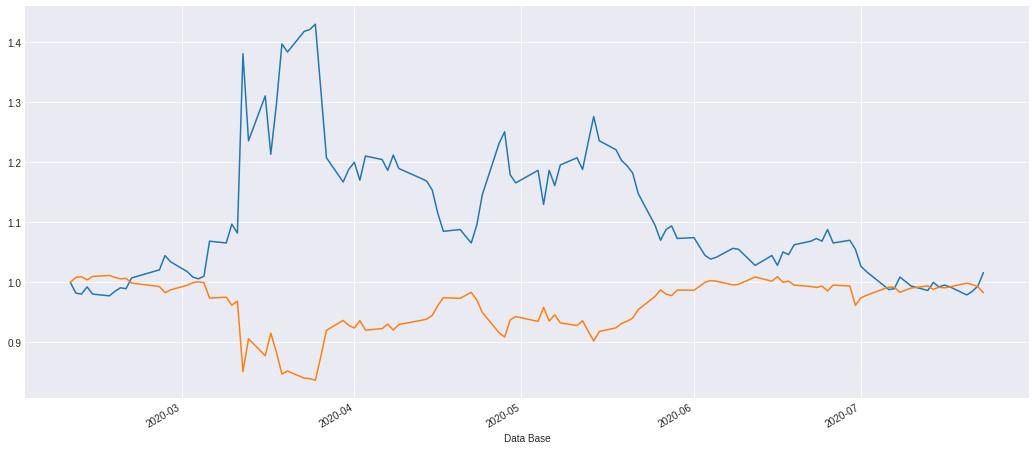

In [25]:
(pre2031['Taxa Compra Manha'] / pre2031['Taxa Compra Manha'].iloc[0]).plot();
(pre2031['PU Compra Manha'] / pre2031['PU Compra Manha'].iloc[0]).plot();

### 2.6 Tesouro IPCA+ 2026

In [26]:
ipca2026 = titulos.loc[('Tesouro IPCA+', '2026-08-15')]
ipca2026

,Taxa Compra Manha,Taxa Venda Manha,PU Compra Manha,PU Venda Manha,PU Base Manha
Data Base,,,,,
2020-02-10,2.65,2.77,2785.55,2764.50,2764.01
2020-02-11,2.58,2.70,2798.39,2777.24,2776.76
2020-02-12,2.56,2.68,2802.40,2781.23,2780.75
2020-02-13,2.58,2.70,2799.33,2778.20,2777.72
2020-02-14,2.54,2.66,2807.15,2785.97,2785.22
2020-02-17,2.49,2.61,2816.44,2795.20,2794.77
2020-02-18,2.53,2.65,2809.76,2788.58,2788.15
2020-02-19,2.56,2.68,2804.86,2783.74,2783.31
2020-02-20,2.50,2.62,2815.90,2794.70,2794.28


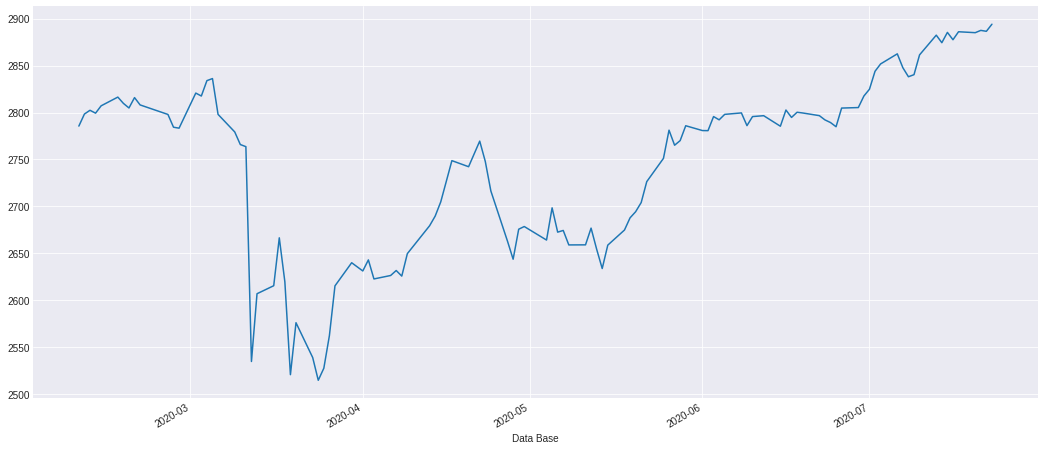

In [27]:
ipca2026['PU Compra Manha'].plot();

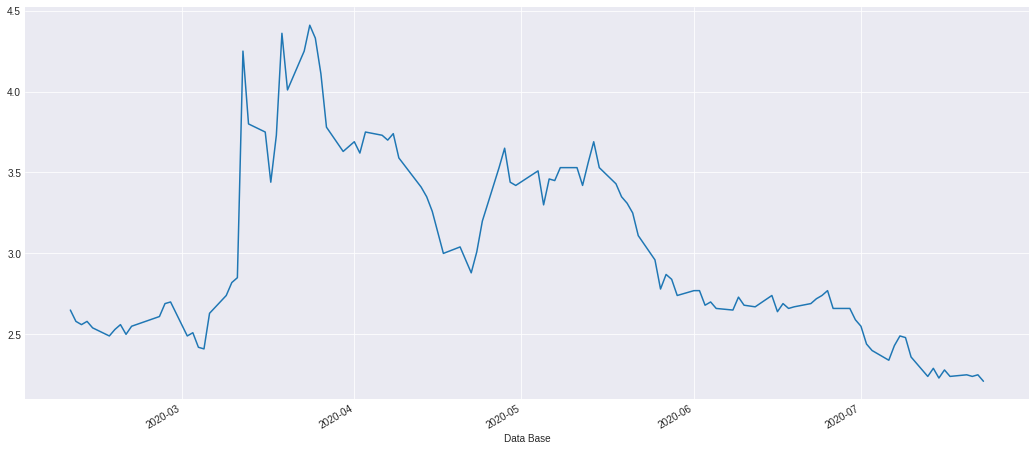

In [28]:
ipca2026['Taxa Compra Manha'].plot();

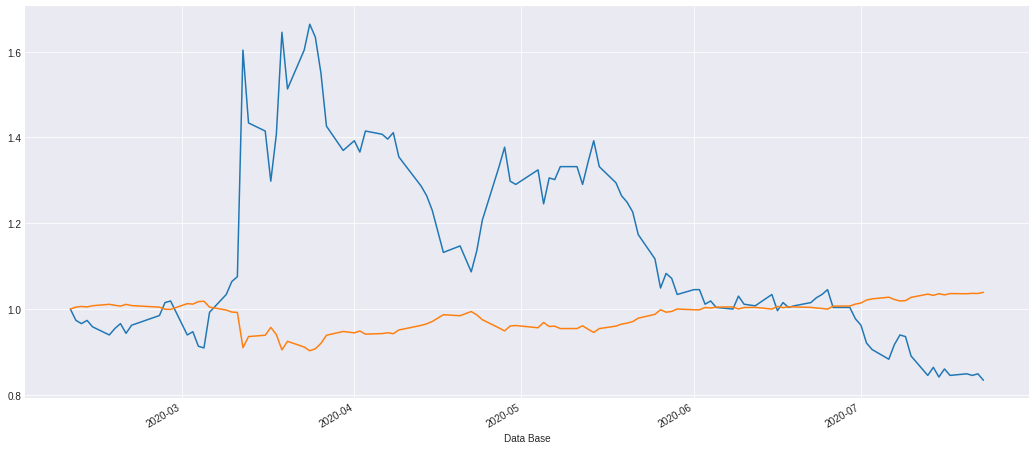

In [29]:
(ipca2026['Taxa Compra Manha'] / ipca2026['Taxa Compra Manha'].iloc[0]).plot();
(ipca2026['PU Compra Manha'] / ipca2026['PU Compra Manha'].iloc[0]).plot();

### 2.7 Tesouro IPCA+ 2035

In [30]:
ipca2035 = titulos.loc[('Tesouro IPCA+', '2035-05-15')]
ipca2035

,Taxa Compra Manha,Taxa Venda Manha,PU Compra Manha,PU Venda Manha,PU Base Manha
Data Base,,,,,
2010-03-08,6.23,6.33,415.52,405.82,405.61
2010-03-09,6.25,6.35,413.78,404.12,403.91
2010-03-10,6.25,6.35,413.99,404.33,404.12
2010-03-11,6.25,6.35,414.20,404.54,404.33
2010-03-12,6.27,6.37,412.69,403.07,402.82
2010-03-15,6.28,6.38,411.87,402.27,402.12
2010-03-16,6.27,6.37,413.00,403.37,403.22
2010-03-17,6.26,6.36,414.13,404.47,404.32
2010-03-18,6.26,6.36,414.28,404.62,404.47


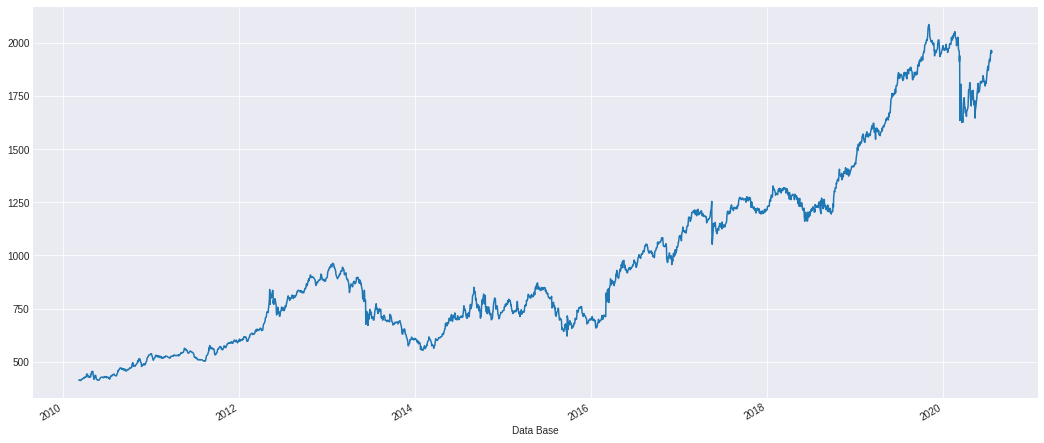

In [31]:
ipca2035['PU Compra Manha'].plot();

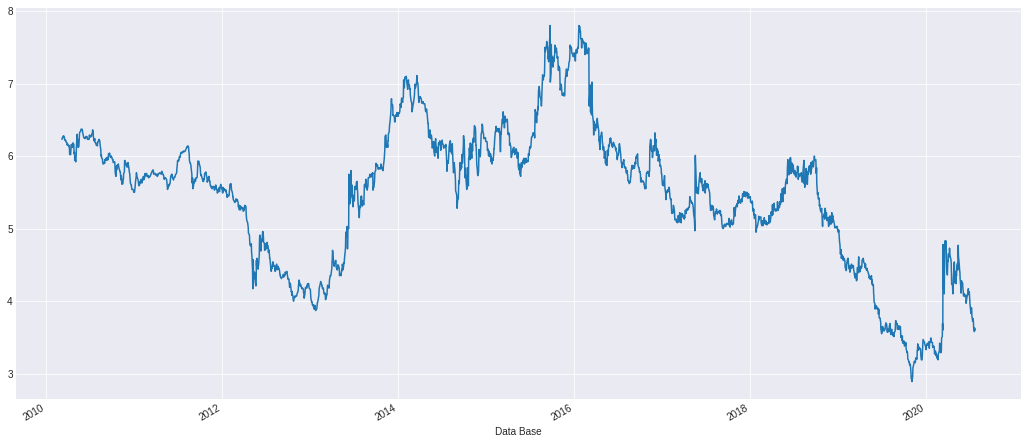

In [32]:
ipca2035['Taxa Compra Manha'].plot();

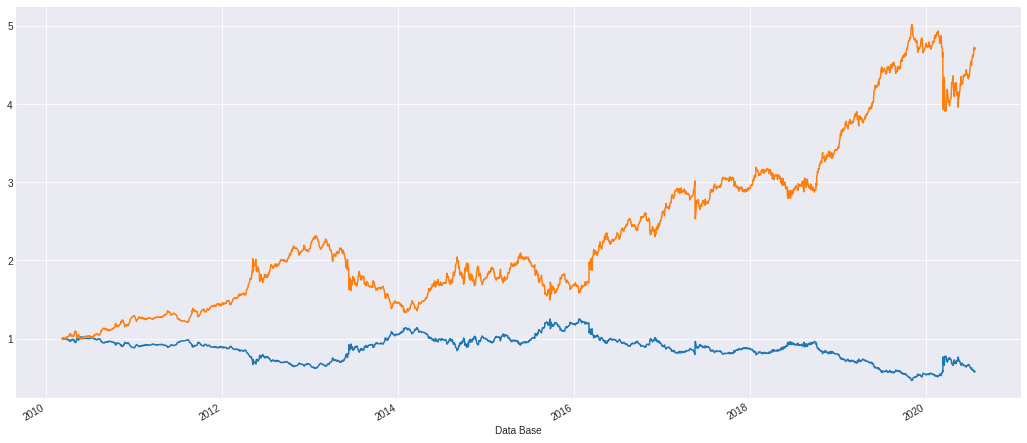

In [33]:
(ipca2035['Taxa Compra Manha'] / ipca2035['Taxa Compra Manha'].iloc[0]).plot();
(ipca2035['PU Compra Manha'] / ipca2035['PU Compra Manha'].iloc[0]).plot();

### 2.8 Tesouro IPCA+ 2045

In [34]:
ipca2045 = titulos.loc[('Tesouro IPCA+', '2045-05-15')]
ipca2045

,Taxa Compra Manha,Taxa Venda Manha,PU Compra Manha,PU Venda Manha,PU Base Manha
Data Base,,,,,
2017-02-08,5.34,5.46,685.78,664.14,663.92
2017-02-09,5.27,5.39,698.96,676.90,676.67
2017-02-10,5.21,5.33,710.67,688.23,687.84
2017-02-13,5.21,5.33,710.90,688.46,688.23
2017-02-14,5.22,5.34,709.23,686.85,686.62
2017-02-15,5.22,5.34,709.49,687.10,686.85
2017-02-16,5.25,5.37,704.09,681.88,681.62
2017-02-17,5.32,5.44,691.53,669.73,669.25
2017-02-20,5.27,5.39,701.09,678.98,678.73


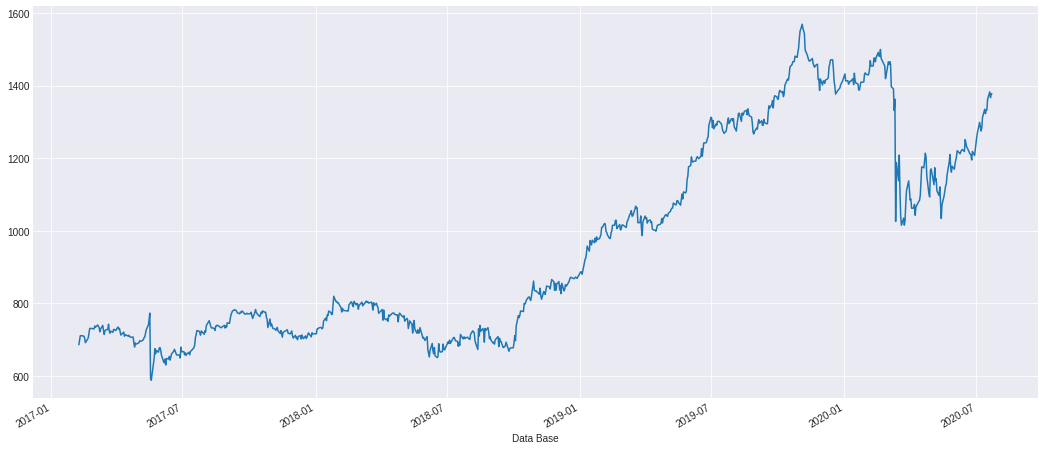

In [35]:
ipca2045['PU Compra Manha'].plot();

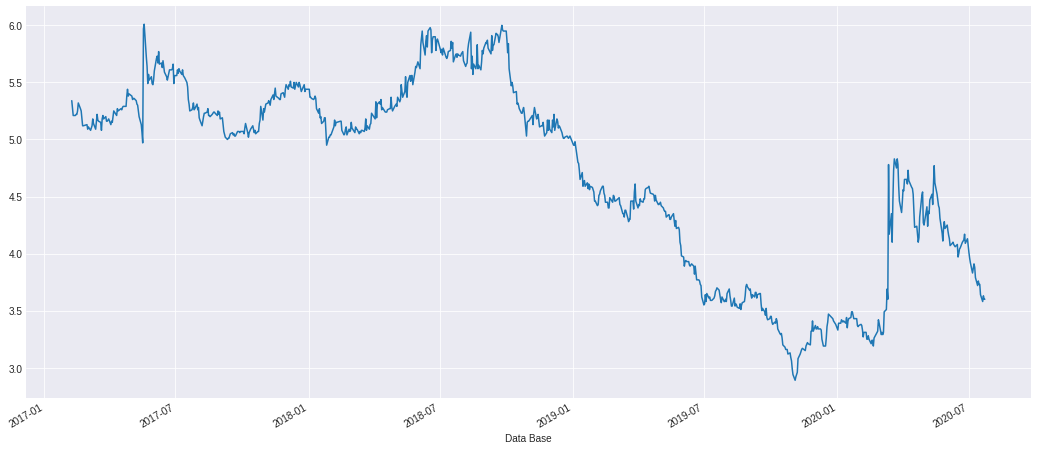

In [36]:
ipca2045['Taxa Compra Manha'].plot();

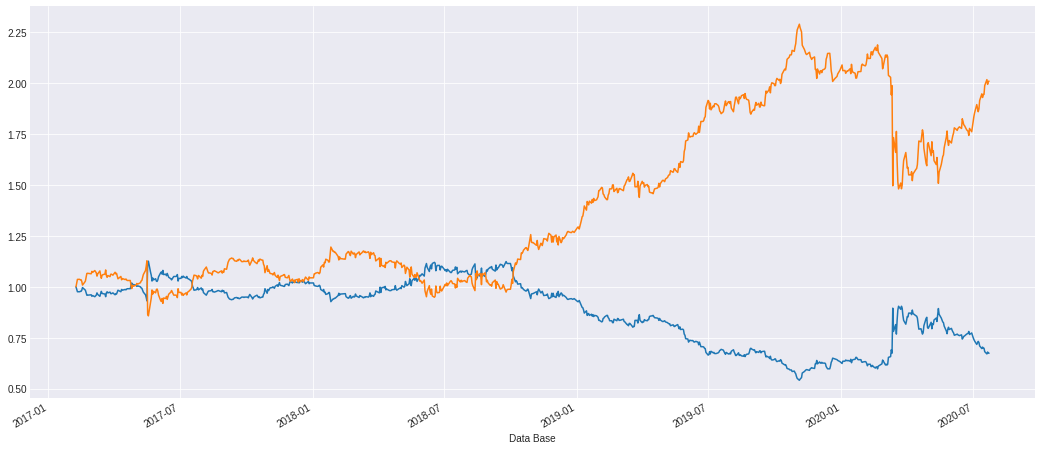

In [37]:
(ipca2045['Taxa Compra Manha'] / ipca2045['Taxa Compra Manha'].iloc[0]).plot();
(ipca2045['PU Compra Manha'] / ipca2045['PU Compra Manha'].iloc[0]).plot();

### 2.9 Tesouro IPCA+ 2055 com Juros Semestrais

In [38]:
ipca2055 = titulos.loc[('Tesouro IPCA+ com Juros Semestrais', '2055-05-15')]
ipca2055

,Taxa Compra Manha,Taxa Venda Manha,PU Compra Manha,PU Venda Manha,PU Base Manha
Data Base,,,,,
2020-02-10,3.42,3.54,5063.37,4956.73,4955.71
2020-02-11,3.36,3.48,5119.00,5010.64,5009.63
2020-02-12,3.36,3.48,5120.02,5011.66,5010.64
2020-02-13,3.40,3.52,5084.54,4977.32,4976.30
2020-02-14,3.37,3.49,5113.38,5005.31,5003.81
2020-02-17,3.34,3.46,5141.86,5032.93,5032.01
2020-02-18,3.37,3.49,5115.22,5007.16,5006.23
2020-02-19,3.37,3.49,5116.14,5008.08,5007.16
2020-02-20,3.34,3.46,5144.62,5035.70,5034.77


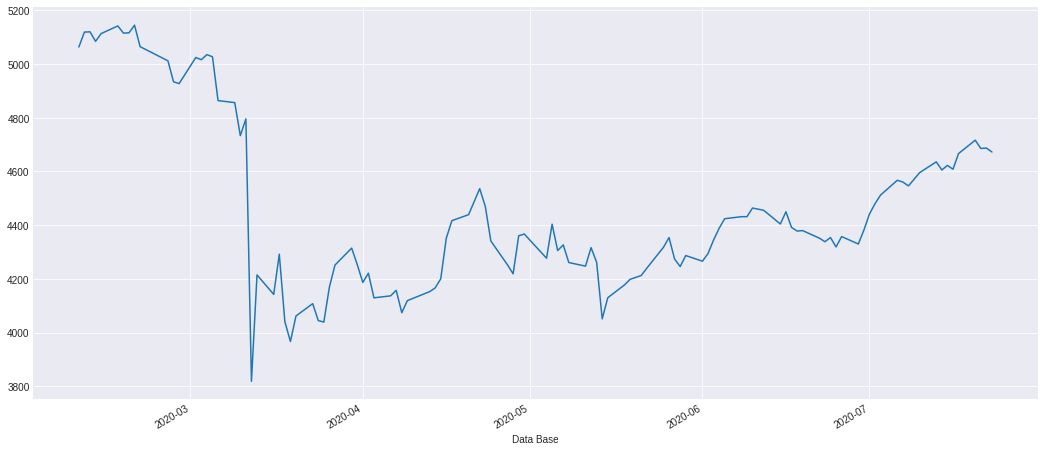

In [39]:
ipca2055['PU Compra Manha'].plot();

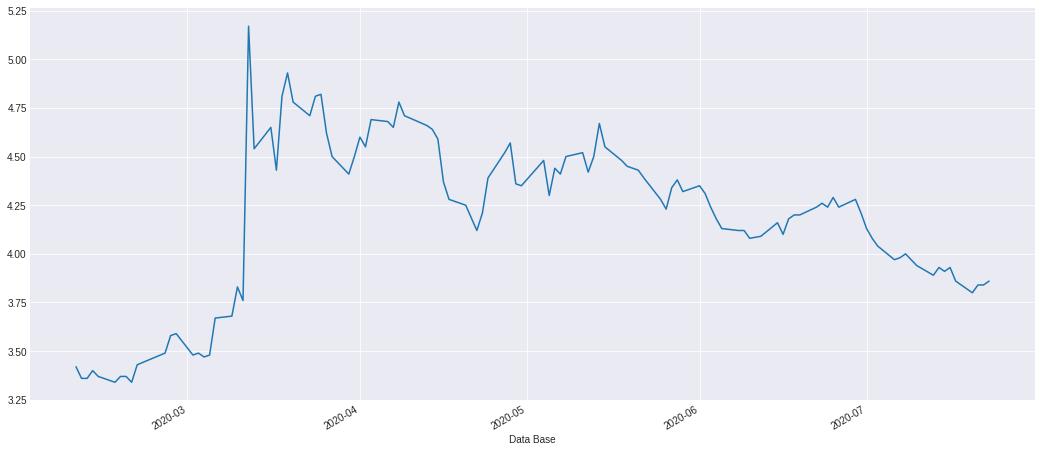

In [40]:
ipca2055['Taxa Compra Manha'].plot();

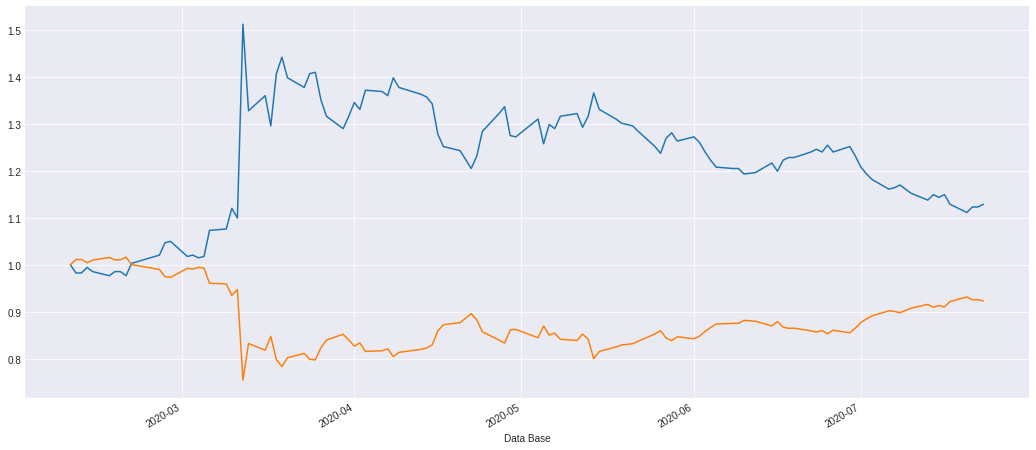

In [41]:
(ipca2055['Taxa Compra Manha'] / ipca2055['Taxa Compra Manha'].iloc[0]).plot();
(ipca2055['PU Compra Manha'] / ipca2055['PU Compra Manha'].iloc[0]).plot();

### 3. Vendas Tesouro Direto
Este conjunto de dados traz o volume de vendas diário do programa Tesouro Direto.

### 3.1 Buscando Dados

In [42]:
vendas = busca_vendas_tesouro()

In [43]:
vendas.sort_index(inplace=True)
vendas

PU  ...        Valor
Tipo Titulo                        Vencimento do Titulo Data Venda                ...             
Tesouro IGPM+ com Juros Semestrais 2005-07-01           2002-01-07   1038.150000  ...      7682.31
                                                        2002-01-08   1035.590000  ...      6213.54
                                                        2002-01-09   1035.400000  ...       207.08
                                                        2002-01-14   1038.166666  ...       622.89
                                                        2002-01-15   1038.640000  ...      1038.64
                                                        2002-01-16   1039.052173  ...     19118.55
                                                        2002-01-17   1039.269911  ...     23487.49
                                                        2002-01-18   1039.259574  ...      9769.03
                                                        2002-01-21   1039.720000  ...     12476.64
                                                        2002-01-22   1040.189743  ...      8113.47
...                                                                          ...  ...          ...
Tesouro Selic                      2025-03-01           2020-07-09  10644.035013  ...  42769861.48
                                                        2020-07-10  10644.947998  ...  36308427.32
                                                        2020-07-13  10645.861054  ...  46075606.01
                                                        2020-07-14  10646.770788  ...  44170257.96
                                                        2020-07-15  10647.692375  ...  40642880.65
                                                        2020-07-16  10648.600958  ...  37899435.66
                                                        2020-07-17  10649.512630  ...  34995469.94
                                                        2020-07-20  10650.433164  ...  40334574.94
                                                        2020-07-21  10651.343520  ...  46243979.53
                                                        2020-07-22  10652.263796  ...  45594565.15

[63456 rows x 3 columns]

### 3.2 Gráficos

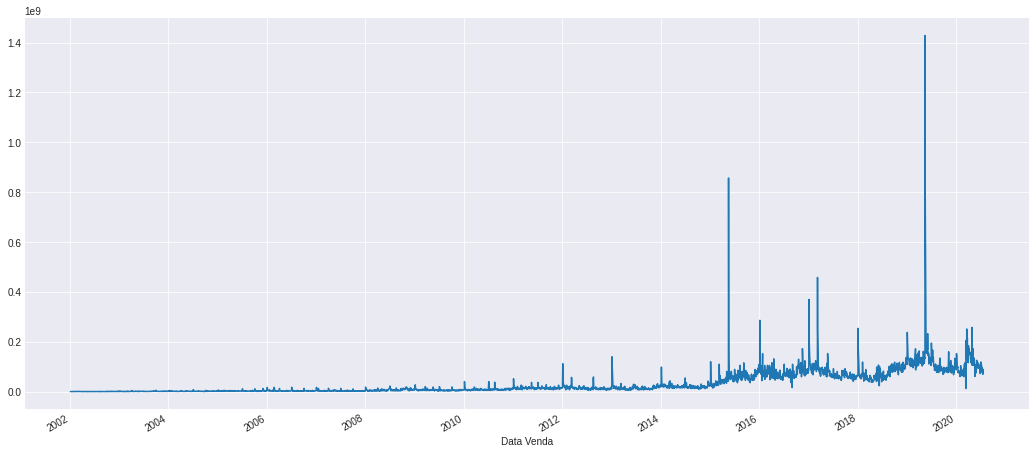

In [44]:
vendas['Valor'].groupby('Data Venda').sum().plot();

### 4. Recompras Tesouro Direto
Esse conjunto da dados contém listagem dos títulos que foram entregues pelo investidor antes do vencimento. Estão listados por dia e por título. Frequência: Atualização diária com dados até dois dias antes à data do arquivo.

### 4.1 Buscando Dados

In [45]:
recompras = busca_recompras_tesouro()

In [46]:
recompras.sort_index(inplace=True)
recompras

Quantidade        Valor
Tipo Titulo                        Vencimento do Titulo Data Resgate                         
Tesouro IGPM+ com Juros Semestrais 2005-07-01           2005-01-13          2.00      3545.04
                                                        2005-02-03          1.00      1783.97
                                                        2005-03-03          2.00      3595.96
                                                        2005-03-10          1.00      1803.81
                                                        2005-03-24          0.20       364.14
                                                        2005-03-31          0.60      1098.15
                                                        2005-04-14          3.60      6666.62
                                                        2005-04-22         36.00     66912.84
                                                        2005-06-02          6.40     11999.94
                                   2005-12-01           2005-01-06        141.20    249321.07
...                                                                          ...          ...
Tesouro Selic                      2025-03-01           2020-07-09       3910.22  41601208.31
                                                        2020-07-10       3386.28  36030077.01
                                                        2020-07-13       3354.26  35692463.97
                                                        2020-07-14       5278.29  56170797.43
                                                        2020-07-15       3132.23  33335587.06
                                                        2020-07-16       4351.83  46319513.49
                                                        2020-07-17       3164.49  33684748.45
                                                        2020-07-20       3085.49  32846664.56
                                                        2020-07-21       4582.17  48783774.89
                                                        2020-07-22       4010.99  42706438.94

[39622 rows x 2 columns]

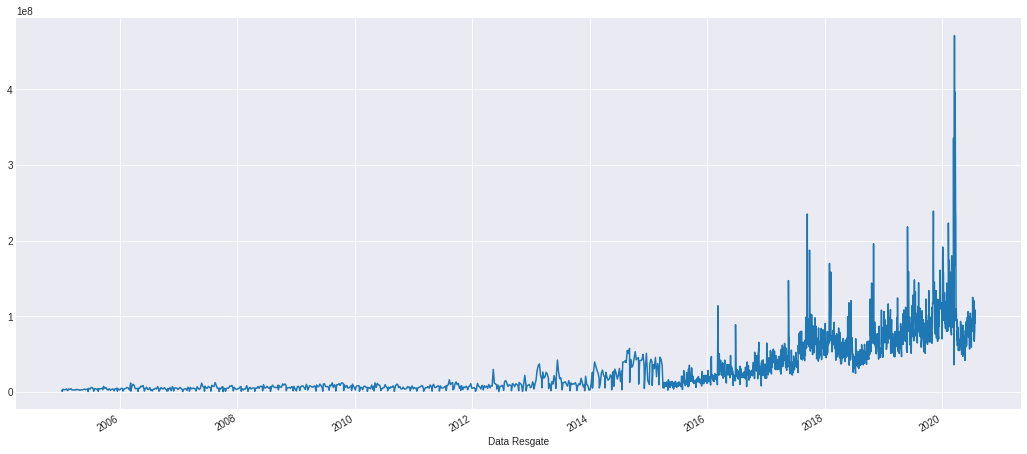

In [47]:
recompras['Valor'].groupby('Data Resgate').sum().plot();

### 4.2 Recompras diárias Tesouro Selic 2025

In [49]:
recompras_selic = recompras.loc[('Tesouro Selic', '2025-03-01')]

In [50]:
fig = px.bar(data_frame=recompras_selic,  x=recompras_selic.index, y='Valor', labels={'x':'Data'})
fig.show()

In [51]:
recompras_selic_semanal = recompras_selic.resample('W').sum()

In [52]:
fig = px.bar(data_frame=recompras_selic_semanal,  x=recompras_selic_semanal.index, y='Valor' )
fig.show()

### 4.3 Resgastes Tesouro Selic vs Índice Bovespa

In [53]:
ibov = yf.download('^BVSP')['Adj Close'].resample('W').last().pct_change()[1:]

[*********************100%***********************]  1 of 1 completed


In [54]:
selic_ibov = pd.concat([recompras_selic_semanal['Valor'].pct_change()[1:], ibov], axis=1).dropna()[1:]
selic_ibov.columns = ['Recompra(%)', 'IBOV(%)']
selic_ibov

,Recompra(%),IBOV(%)
Date,,
2019-02-24,0.236251,0.003691
2019-03-03,0.423072,-0.033529
2019-03-10,-0.219953,0.008044
2019-03-17,1.231367,0.039553
2019-03-24,0.179772,-0.054490
2019-03-31,0.579274,0.017923
2019-04-07,-0.185600,0.017744
2019-04-14,0.124599,-0.043591
2019-04-21,0.030708,0.018336


In [55]:
fig = go.Figure(data=[
    go.Bar(name='Recompras Selic(%)', x=selic_ibov.index,  y=selic_ibov['Recompra(%)']),
    go.Bar(name='IBOV(%)', x=selic_ibov.index,  y=selic_ibov['IBOV(%)']),
])
fig.update_layout(barmode='group')
fig.show()

In [56]:
selic_ibov.corr()

,Recompra(%),IBOV(%)
Recompra(%),1.00000,-0.23509
IBOV(%),-0.23509,1.00000
